# A comprehensive study of DPNets on the logistic map

In [323]:
%load_ext autoreload
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml', register_jax_pytree=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [354]:
%autoreload 2
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.linalg
from scipy.integrate import romb
from rich.console import Console
from rich.table import Table
#Set plotting styles
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

#Torch imports
import lightning
import torch
from torch.utils.data import DataLoader

#Kooplearn imports
from kooplearn.abc import FeatureMap
from kooplearn.models.feature_maps import ConcatenateFeatureMaps
from kooplearn.datasets import LogisticMap
from kooplearn._src.metrics import directed_hausdorff_distance
from kooplearn.nn.data import TrajToContextsDataset

## Creating the standard dataset

In [266]:
logistic = LogisticMap(N = configs.N)

In [288]:
sample_traj = logistic.sample(0.5, 15000)
dataset = {
    'train': sample_traj[:8000],
    'validation': sample_traj[8000:10000],
    'test': sample_traj[10000:]
}

The logistic map is a non-normal dynamical system. This can be visualized by comparing the eigenvalues against the singular values of the transfer operator:

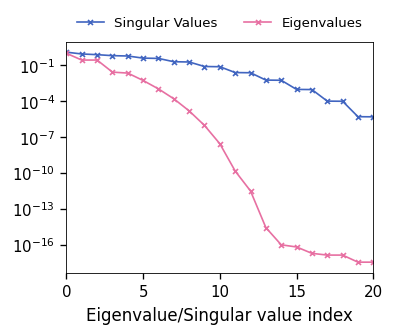

In [285]:
plt.plot(logistic.svals(), 'x-', label= 'Singular Values')
plt.plot(np.abs(logistic.eig()), 'x-', label = 'Eigenvalues')
plt.margins(x=0)
plt.yscale('log')
plt.xlabel("Eigenvalue/Singular value index")
plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1., 1, 0), ncol=2, fontsize=8)

## Setting up an evaluation scheme.

### Population estimators
As we are able to compute everything for this system, we evaluate the performance of `DPNets` in two stages. In the first stage we take three different feature maps:
1. Chebyshev polynomials up to order $\ell$
2. `VAMPNets` with latent dimension $\ell$ (MLP architecture tbd)
3. `DPNets` with latend dimension $\ell$ (MLP architecture tbd)

Given $\phi \colon [0, 1]\to \mathbb{R}^{\ell}$, we evaluate $C_{ij} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(x) \pi(dx)$, where $\pi$ is the invariant distribution. And the cross covariance $C_{ij}^{\times} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(y) \pi(dx)p(x, dy) = \sum_{n = 0}^{N}\left(\int_{0}^{1} \phi_{i}(x)\alpha_{n}(x)\pi(dx)\right)\left(\int_{0}^{1} \phi_{j}(y)\beta_{n}(y)dy\right)$. As the kernel is separable, I just need to compute $2(N + 1)$ single integrals. 

Now, the OLS Transfer operator estimator is $G_{{\rm OLS}} = C^{\dagger}C^{\times}$, from which I can compute:
1. Directed Hausdorff spectral distance
2. Approximation error $\Vert [I - P_{\mathcal{H}}]\mathcal{T}|_{\mathcal{H}}\Vert$, for which $\mathcal{P}$ and $\mathcal{S}$ are proxies.
3. VAMP-score $\mathcal{P}$ + something related to metric distortion. An example could be $\mathcal{P}/\kappa (C)$

### Empirical estimators
In the second stage we pull into the ring every Koopman estimator we have and we compute, from data:

- Directed Hausdorff distance as a metric for the spectral estimation.
- MAE on 1-step ahead conditional expectation. Even if the system is stochastic, since it is of the form $X_{t + 1} = F(X_t) + \xi_{t}$ where $\xi_{t}$ is zero-mean, the expected value conditioned on $X_t = x$ is just $F(x)$.

# Population validators

In [268]:
def population_covs(feature_map: FeatureMap, pow_of_two_k: int = 12):
    """Computes the population covariance and cross-covariance"""
    x = np.linspace(0, 1, 2**pow_of_two_k + 1)
    vals, lv = logistic.eig(eval_left_on=x)
    perron_eig_idx = np.argmax(np.abs(vals))
    pi = lv[:, perron_eig_idx]
    assert np.isreal(pi).all()
    pi = pi.real
    pi = pi/romb(pi, dx = 1/2**pow_of_two_k) #Normalization of \pi
    #Evaluating the feature map
    phi = feature_map(x) # [2**pow_of_two_k + 1, d]
    #Covariance
    cov_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*phi.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    cov = romb(cov_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    #Cross-covariance
    alphas = np.stack([logistic.noise_feature_composed_map(x, n) for n in range(logistic.N + 1)], axis = 1)
    betas = np.stack([logistic.noise_feature(x, n) for n in range(logistic.N + 1)], axis = 1)

    cov_alpha_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*alphas.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    cov_beta_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*betas.reshape(2**pow_of_two_k + 1, 1, -1)

    cov_alpha = romb(cov_alpha_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    cov_beta = romb(cov_beta_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    
    cross_cov = cov_alpha@(cov_beta.T)
    return cov, cross_cov

def evaluate_representation(feature_map: FeatureMap):
    report = {}
    #Compute OLS estimator
    cov, cross_cov = population_covs(feature_map)
    OLS_estimator = np.linalg.solve(cov, cross_cov)
    #Eigenvalue estimation
    OLS_eigs = np.linalg.eigvals(OLS_estimator)
    report['hausdorff-dist'] = directed_hausdorff_distance(OLS_eigs, logistic.eig())
    #VAMP2-score
    M = np.linalg.multi_dot([np.linalg.pinv(cov, hermitian=True), cross_cov, np.linalg.pinv(cov, hermitian=True), cross_cov.T])
    report['VAMP2-score'] = np.trace(M)
    #Metric distortion
    cov_eigs = np.linalg.eigvalsh(cov)
    report['fro-Id-cov'] = np.mean((cov_eigs - np.ones_like(cov_eigs))**2)
    report['feature-map'] = feature_map
    return report

def tabulate_reports(reports):
    console = Console()
    table = Table(show_header=True, header_style="bold")
    table.add_column("Representation", justify='right')
    table.add_column("Hausdorff dist",justify='center')
    table.add_column("VAMP2",justify='center')
    table.add_column("||Id - cov||^2",justify='center')
    for model_name, model_report in reports.items():
        hausdorff = f"{model_report['hausdorff-dist']:.3f}"
        SVD_err = f"{model_report['VAMP2-score']:.3f}"
        fro_dist = f"{model_report['fro-Id-cov']:.3f}"
        table.add_row(model_name, hausdorff, SVD_err, fro_dist)
    console.print(table)

def flatten_reports(reports):
    #Reports must all be of depth 1 and with the same shape. No checks are performed 
    flattened = {}
    for model_name, model_report in reports.items():
        for report_stub, value in model_report.items():
            if report_stub in flattened:
                flattened[report_stub].append(value)
            else:
                flattened[report_stub] = [value]
    return flattened

In [269]:
def ChebyT(order: int = 3):
    def scaled_chebyt(n, x):
        return scipy.special.eval_chebyt(n, 2*x - 1)
    fn_list = [partial(scaled_chebyt, n) for n in range(order + 1)]
    return ConcatenateFeatureMaps(fn_list)   

def ChebyU(order: int = 3):
    def scaled_chebyu(n, x):
        return scipy.special.eval_chebyu(n, 2*x - 1)
    fn_list = [partial(scaled_chebyu, n) for n in range(order + 1)]
    return ConcatenateFeatureMaps(fn_list)    

In [271]:
reports = {}
for i in range(1, 41):
    model_name = f"ChebyT-{i}"
    reports[model_name] = evaluate_representation(ChebyT(i))
flattened = flatten_reports(reports)

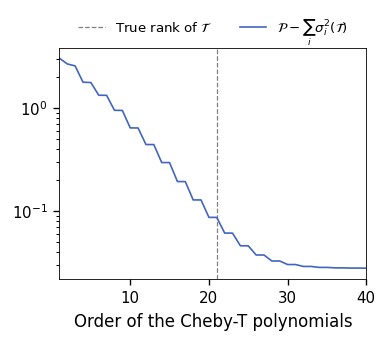

In [287]:
fig, ax = plt.subplots()
svd_error = np.sum(logistic.svals()**2) - flattened['VAMP2-score']
num_orders = len(svd_error)
ax.axvline(x=logistic.N + 1, linestyle='--', color='k', alpha=0.5, lw=0.75, label ='True rank of $\\mathcal{T}$')
ax.plot(np.arange(1, num_orders + 1), svd_error, label = r"$\mathcal{P} - \sum_{i} \sigma_{i}^{2}(\mathcal{T})$")

ax.set_xlabel('Order of the Cheby-T polynomials')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 0.95, 1, 0), ncol=2, fontsize=8)


### Defining a standard MLP architecture

In [318]:
from collections import OrderedDict
from copy import deepcopy
class SimpleMLP(torch.nn.Module):
    def __init__(self, hidden_dim: int, layer_dims: list[int], activation = torch.nn.SiLU):
        super().__init__()
        self.layer_dims = deepcopy(layer_dims)
        self.layer_dims.append(hidden_dim)
        self.layer_dims.insert(0, 1)
        #Create an MLP from the layer dimensions
        module_dict = OrderedDict()
        for i in range(len(self.layer_dims) - 2):
            module_dict[f"linear_{i}"] = torch.nn.Linear(self.layer_dims[i], self.layer_dims[i+1])
            module_dict[f"activation_{i}"] = activation()
        module_dict[f"linear_{len(self.layer_dims) - 2}"] = torch.nn.Linear(self.layer_dims[-2], self.layer_dims[-1])
        self.mlp = torch.nn.Sequential(module_dict)
    
    def forward(self, x):
        return self.mlp(x)

### Tranining VAMPNets

In [346]:
#Preparing the data
train_ds = TrajToContextsDataset(torch.from_numpy(dataset['train']).float())
val_ds = TrajToContextsDataset(torch.from_numpy(dataset['validation']).float())

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [377]:
%autoreload 2
from kooplearn.models.feature_maps import VAMPNet

trainer_kwargs = {
    'accelerator': 'cpu',
    'devices': 1,
    'max_epochs': 200,  
    'log_every_n_steps': 3,
}
trainer = lightning.Trainer(**trainer_kwargs)

lobe_kwargs = {
    'hidden_dim': 5,
    'layer_dims': configs.mlp_layer_dims
}
#Defining the model
feature_map = VAMPNet(
    SimpleMLP,
    torch.optim.Adam,
    {'lr': 1e-6},
    trainer,
    lobe_kwargs,
    lobe_timelagged=SimpleMLP,
    lobe_timelagged_kwargs=lobe_kwargs,
    center_covariances=False,
    seed=configs.rng_seed
)

Global seed set to 0


In [378]:
feature_map.fit(train_dl)


  | Name            | Type      | Params
----------------------------------------------
0 | lobe            | SimpleMLP | 19.1 K
1 | lobe_timelagged | SimpleMLP | 19.1 K
----------------------------------------------
38.2 K    Trainable params
0         Non-trainable params
38.2 K    Total params
0.153     Total estimated model params size (MB)


Fitting VAMPNet. Lookback window length set to 1


Training: 0it [00:00, ?it/s]

/Users/pietronovelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [357]:
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING) #Remove annoying logging
#LR behaviour after 1 epoch
lrs = torch.logspace(-7, -4, 100)
scores = []
for lr in lrs:
    trainer_kwargs = {
        'accelerator': 'cpu',
        'devices': 1,
        'max_epochs': 2,  
        'log_every_n_steps': 3,
        'enable_progress_bar': False,
        'enable_model_summary': False
    }
    trainer = lightning.Trainer(**trainer_kwargs)

    lobe_kwargs = {
        'hidden_dim': 5,
        'layer_dims': configs.mlp_layer_dims
    }

    #Defining the model
    feature_map = VAMPNet(
        SimpleMLP,
        torch.optim.Adam,
        {'lr': lr.item()},
        trainer,
        lobe_kwargs,
        lobe_timelagged=SimpleMLP,
        lobe_timelagged_kwargs=lobe_kwargs,
        center_covariances=False,
        seed=1
    )
    feature_map.fit(train_dl, verbose = False)
    scores.append(feature_map.lightning_trainer.logged_metrics['train/VAMP_score'].item())

### Training DPNets seems hard: no learning rate give a whatsoever update after 2 epochs

Text(0.5, 0, 'Learning rate')

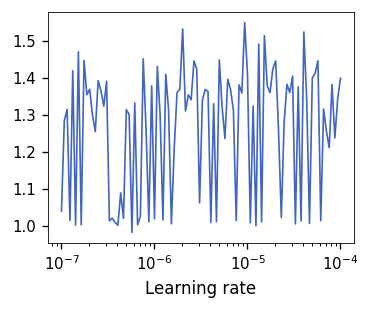

In [358]:
plt.plot(lrs, scores)
plt.xscale('log')
plt.xlabel('Learning rate')